In [1]:
from tqdm import tqdm
import csv
import pickle
import PIL.Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import transforms, datasets

%matplotlib inline

# Table of Contents

* [Preprocessing](#Preprocessing)
* [Model](#Model)
* [Training](#Training)
* [Testing](#Testing)

# Preprocessing

In [2]:
# load training images
with open('./Vision_task_dataset_public/train_image.pkl', 'rb') as f:
    images = pickle.load(f)
images = np.array(images)

# load labels
with open('./Vision_task_dataset_public/train_label.pkl', 'rb') as f:
    labels = pickle.load(f)
labels = np.array(labels)

images.shape, labels.shape

((8000, 784), (8000,))

### Labels: 4

In [3]:
# check labels
np.unique(labels)

array([0, 2, 3, 6])

In [4]:
# test labels at regular interval
labels[0], labels[2000], labels[4000], labels[7999]

(0, 2, 3, 6)

Looks like data's sequentially arranged as per labels!

**Convert labels into 0, 1, 2 and 3 respectively as PyTorch expects them in this format.**

In [5]:
labels[labels == 2] = 1
labels[labels == 3] = 2
labels[labels == 6] = 3

In [6]:
# check labels
print(np.unique(labels))
labels[0], labels[2000], labels[4000], labels[7999]

[0 1 2 3]


(0, 1, 2, 3)

### Images

In [7]:
images[0].shape

(784,)

In [8]:
np.sqrt(784)

28.0

It seems that every image is a square of size 28x28.

**Try** plotting those images.

(28, 28)


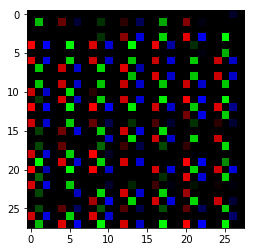

In [9]:
img = images[0].reshape(28, 28)
print(img.shape)
img = PIL.Image.fromarray(img, mode='RGB')
plt.imshow(img)

(28, 28)


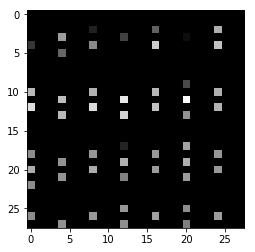

In [11]:
img = images[4000].reshape(28, 28)
print(img.shape)
img = PIL.Image.fromarray(img, mode='L')
plt.imshow(img)

<div style="color:red">Looks something off!</div>  
Trying in a different way...

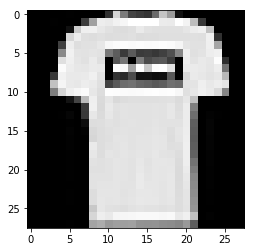

In [12]:
# label 0 image
plt.imshow(images[0].reshape(1, 28, 28).squeeze(), cmap='Greys_r')

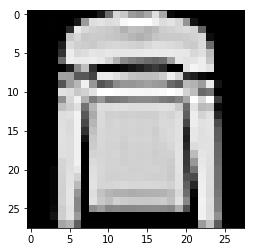

In [14]:
# label 1 image (corresponding to original 2 label)
plt.imshow(images[2000].reshape(28, 28), cmap='Greys_r')

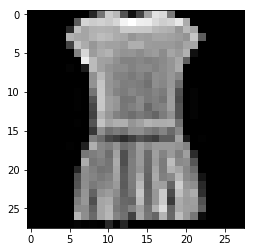

In [13]:
# label 2 image (corresponding to original label 3)
plt.imshow(images[4000].reshape(28, 28), cmap='Greys_r')

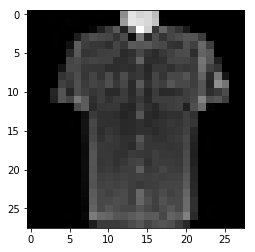

In [16]:
# label 3 image (corresponding to original label 6)
plt.imshow(images[7999].reshape(28, 28), cmap='Greys_r')

### Create PyTorch datasets and DataLoaders

First split data using  sklearn `train_test_split` then convert into tensor

In [14]:
# randomly split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0)

In [15]:
# convert into pytorch tensors
X_train = torch.stack([torch.from_numpy(np.array(i)) for i in X_train])
X_test = torch.stack([torch.from_numpy(np.array(i)) for i in X_test])
y_train = torch.stack([torch.from_numpy(np.array(i)) for i in y_train])
y_test = torch.stack([torch.from_numpy(np.array(i)) for i in y_test])

In [16]:
# reshape into [C, H, W]
X_train = X_train.reshape((-1, 1, 28, 28)).float()
X_test = X_test.reshape((-1, 1, 28, 28)).float()

In [17]:
# create dataset and dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

valid_dataset = torch.utils.data.TensorDataset(X_test, y_test)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64)

In [18]:
len(train_loader)

100

In [19]:
# for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Test data shapes of one batch one last time before moving on.

In [20]:
dataiter = iter(train_loader)
tt, ll = dataiter.next()
print(type(ll))
print(tt.shape)
print(ll.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Now, everything seems perfect!  
<div style="color:green">Ready to move on...</div>

# Model

Tried different combination of layers, finally using 3 conv > 2 fully connected layers with dropout probability 0.5. This combination gave better validation results compared to others.

conv size: (W-F+2P)/S + 1

In [57]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # input image: (1, 28, 28)
        # set padding s.t. conv layer has same height and width as previous layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        # (16, 28, 28) --> (16, 14, 14) (halved by max-pool)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # (32, 7, 7)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # (64, 3, 3)
        self.fc1 = nn.Linear(64*3*3, 128)
#         self.fc2 = nn.Linear(256, 128)
        # no of labels `N_CLASSES`: 4
        self.fc3 = nn.Linear(128, 4)

        # dropout 0.2 drop probability
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten images input
        x = x.view(-1, 64*3*3)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = F.relu(self.fc2(x))

        # output so no dropout here
        x = self.fc3(x)

        return x


Using **Cross-entropy** loss and **Adam** optimizer with a learning rate of 0.001.

In [66]:
model = Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
steps = 0

In [67]:
print(model)

Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.5)
)


In [68]:
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]           4,640
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          18,496
         MaxPool2d-6             [-1, 64, 3, 3]               0
           Dropout-7                  [-1, 576]               0
            Linear-8                  [-1, 128]          73,856
            Linear-9                    [-1, 4]             516
Total params: 97,668
Trainable params: 97,668
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.37
Estimated Total Size (MB): 0.59
---------------------------------------------

# Training

In [69]:
# initialize tracker for losses
train_losses, test_losses = [], []
valid_loss_min = np.Inf

for e in range(epochs):
    running_loss = 0
    
    ### training loop ###
    for images, labels in train_loader:
        
        # clear the gradients 
        optimizer.zero_grad()
        # forward pass
        outputs = model(images)
        # prediction
        _, preds = torch.max(outputs, 1)
        # calculate loss
        loss = criterion(outputs, labels)
        # bacward pass
        loss.backward()
        # optimization
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        
        ### validation loop ###
        valid_loss = 0
        accuracy = 0
        
        # turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()

            for images, labels in valid_loader:
                outputs = model(images)
                valid_loss += criterion(outputs, labels)
                
        # set model back to training mode
        model.train()
        
        # calculate average losses (per epoch)
        train_avg_loss = running_loss/len(train_loader)
        valid_avg_loss = valid_loss/len(valid_loader)
        train_losses.append(train_avg_loss)
        test_losses.append(valid_avg_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_avg_loss),
              "Valid Loss: {:.3f}.. ".format(valid_avg_loss))
#               "Test Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
        if valid_avg_loss <= valid_loss_min:
            print(f'Validation loss decreased ({valid_loss_min:.3f} --> {valid_avg_loss:.3f}).  Saving model ...')
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_avg_loss


Epoch: 1/20..  Training Loss: 0.887..  Valid Loss: 0.593.. 
Validation loss decreased (inf --> 0.593).  Saving model ...
Epoch: 2/20..  Training Loss: 0.565..  Valid Loss: 0.514.. 
Validation loss decreased (0.593 --> 0.514).  Saving model ...
Epoch: 3/20..  Training Loss: 0.501..  Valid Loss: 0.460.. 
Validation loss decreased (0.514 --> 0.460).  Saving model ...
Epoch: 4/20..  Training Loss: 0.461..  Valid Loss: 0.461.. 
Epoch: 5/20..  Training Loss: 0.431..  Valid Loss: 0.436.. 
Validation loss decreased (0.460 --> 0.436).  Saving model ...
Epoch: 6/20..  Training Loss: 0.419..  Valid Loss: 0.416.. 
Validation loss decreased (0.436 --> 0.416).  Saving model ...
Epoch: 7/20..  Training Loss: 0.395..  Valid Loss: 0.415.. 
Validation loss decreased (0.416 --> 0.415).  Saving model ...
Epoch: 8/20..  Training Loss: 0.365..  Valid Loss: 0.391.. 
Validation loss decreased (0.415 --> 0.391).  Saving model ...
Epoch: 9/20..  Training Loss: 0.351..  Valid Loss: 0.383.. 
Validation loss decre

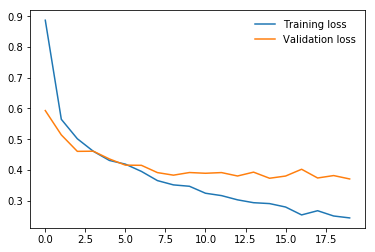

In [70]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [71]:
# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model.pt'))

# Testing

In [72]:
# load testing data
with open('./Vision_task_dataset_public/test_image.pkl', 'rb') as f:
    test = pickle.load(f)
test = np.array(test)
test.shape

(2000, 784)

In [73]:
# convert into pytorch tensor
test = torch.stack([torch.from_numpy(np.array(i)) for i in test])

In [74]:
# reshape into [B, C, H, W]
test = test.reshape((-1, 1, 28, 28)).float()
test.shape, test.dtype

(torch.Size([2000, 1, 28, 28]), torch.float32)

<div style="color:blue">Check prediction on single image</div>

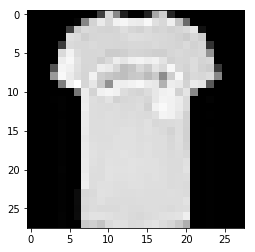

In [75]:
plt.imshow(test[0].reshape(1, 28, 28).squeeze(), cmap='Greys_r')

In [76]:
# convert output probabilities to predicted class
_, preds = torch.max(model(test[0].unsqueeze_(0)), 1)
preds.item()

0

Looks like the correct predicted value!  

**<div style="color:blue">Prediction on all test images</div>**

In [77]:
result = []
for i in range(len(test)):
    _, preds = torch.max(model(test[i].unsqueeze_(0)), 1)
    result.append(preds.item())
result = np.array(result)

In [78]:
result[:300]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0,
       3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 3, 3, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 0, 0, 1, 0, 0, 3,
       0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 3, 0, 0, 0, 1, 0, 0, 0, 0])

**Convert labels back to 6, 3, 2, and 0 from 3, 2, 1, and 0 respectively.**

In [79]:
result[result == 3] = 6
result[result == 2] = 3
result[result == 1] = 2

In [80]:
result[:300]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 0,
       6, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 6, 0, 3, 0, 0, 0, 0, 0, 0, 0, 6, 6, 0, 0, 0, 0, 6, 6, 6, 0, 0,
       0, 0, 0, 0, 3, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 6, 0, 0,
       0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 3,
       0, 0, 0, 6, 6, 0, 6, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 6, 0, 0, 6, 0, 0, 6, 0, 0, 0, 0, 0, 2, 0, 0, 6,
       0, 6, 0, 0, 0, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 2, 6, 0, 0, 0, 2, 0, 0, 0, 0])

In [83]:
np.unique(result)

array([0, 2, 3, 6])

Check prediction value statistics

In [85]:
from collections import Counter
Counter(result)

Counter({0: 544, 6: 499, 2: 473, 3: 484})

Perfect! Ready to submit...

In [81]:
# using zip so as to be able to use csv writer to write data in columns instead of rows
rows = zip(range(len(result)), result)

In [82]:
with open('harshit_kumar.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['image_index', 'class'])
    for row in rows:
        writer.writerow(row)